In [1]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.forecasting.arch import ARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. data

In [2]:
TICKER = "BZ=F"
START = "2010-01-01"
END = "2025-06-30"
data = yf.download(TICKER, start=START, end=END, progress=False)
spot = data['Close'][TICKER]
returns = np.log(spot / spot.shift(1)).dropna()
returns.index = pd.PeriodIndex(returns.index, freq='D')
TRAIN_START = START
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
TEST_END = END

train_returns = returns[TRAIN_START:TEST_START]
test_returns = returns[TEST_START:TEST_END]

# Random global for the notebook

seed = 42
# Set seeds for Python libraries
random.seed(seed)
np.random.seed(seed)
# Set seed for TensorFlow
tf.random.set_seed(seed)


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_42660\540630726.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END, progress=False)


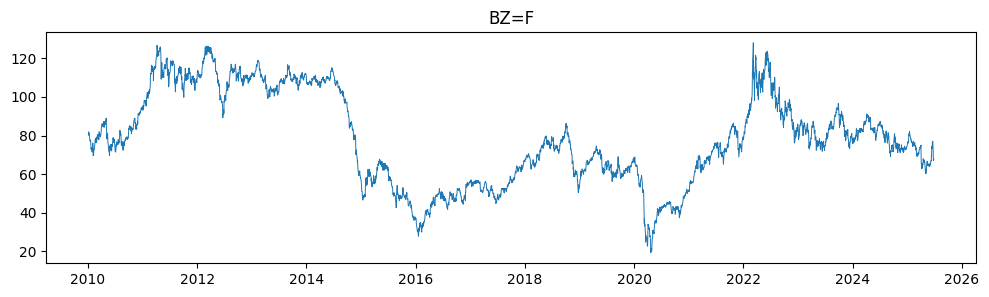

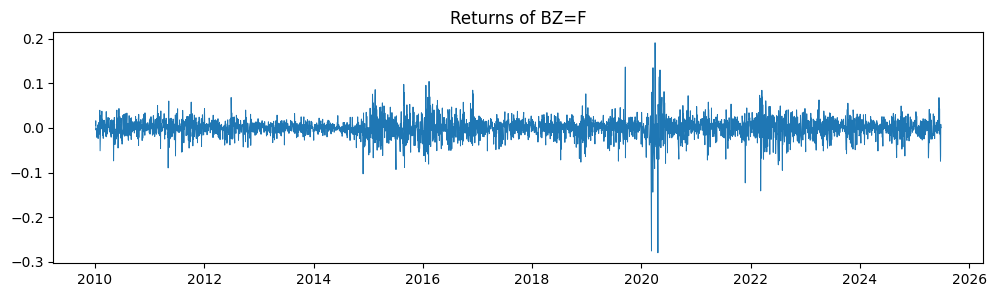

In [3]:
plt.figure(figsize=(12,3))
plt.plot(spot, linewidth=0.7)
plt.title(TICKER)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(returns.index.to_timestamp(), returns.values, label='Daily Returns', linewidth=0.7)
plt.title(f"Returns of {TICKER}")
plt.show()

# 2. Models
## 2.1. GARCH

In [4]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8784.99
Distribution:                  Normal   AIC:                          -17564.0
Method:            Maximum Likelihood   BIC:                          -17545.5
                                        No. Observations:                 3488
Date:                Tue, Oct 07 2025   Df Residuals:                     3488
Time:                        08:04:50   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0662e-05  6.829e-12  1.561e+06      0.000 [1.

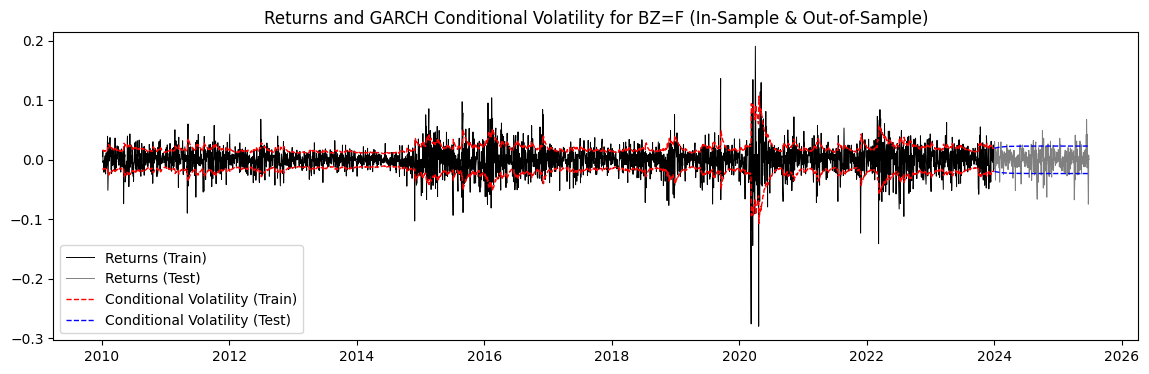

In [5]:
conditional_volatility_in_sample_GARCH = np.sqrt(forecaster.predict_var(fh=train_returns.index))
conditional_variance_in_sample_GARCH = forecaster.predict_var(fh=train_returns.index)
conditional_variance_out_of_sample_GARCH = forecaster.predict_var(fh=test_returns.index)
conditional_volatility_out_of_sample_GARCH = np.sqrt(conditional_variance_out_of_sample_GARCH)

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample_GARCH.index.to_timestamp(), conditional_volatility_in_sample_GARCH.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_in_sample_GARCH.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

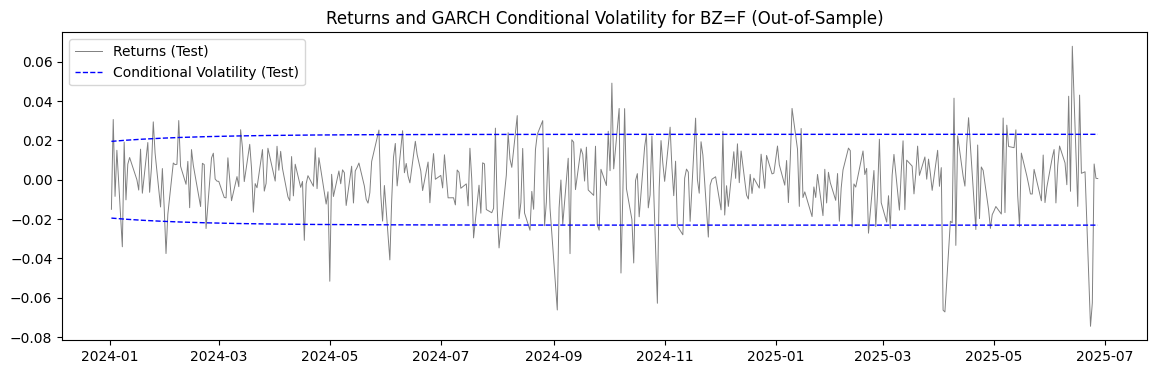

In [6]:
plt.figure(figsize=(14, 4))
#plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (Out-of-Sample)")
plt.legend()
plt.show()

In [7]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GARCH

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
# corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
# print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000315
Root Mean Squared Error (RMSE): 0.017740
Mean Absolute Error (MAE): 0.012906


## 2.2. GJR-GARCH

In [8]:
# Fit ARCH model on returns
forecaster = ARCH(p=1, q=1, o=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster.fit(train_returns)
print(forecaster.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                8805.47
Distribution:                  Normal   AIC:                          -17602.9
Method:            Maximum Likelihood   BIC:                          -17578.3
                                        No. Observations:                 3488
Date:                Tue, Oct 07 2025   Df Residuals:                     3488
Time:                        08:04:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0556e-05  8.196e-12  1.288e+06      0.000 [1.

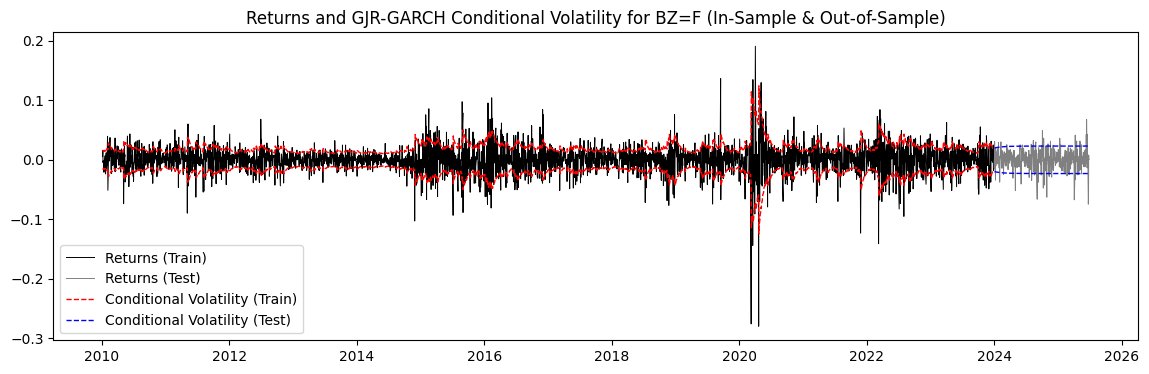

In [9]:
conditional_variance_in_sample_GJRGARCH = forecaster.predict_var(fh=train_returns.index)
conditional_volatility_in_sample_GJRGARCH = np.sqrt(forecaster.predict_var(fh=train_returns.index))
conditional_variance_out_of_sample_GJRGARCH = forecaster.predict_var(fh=test_returns.index)
conditional_volatility_out_of_sample_GJRGARCH = np.sqrt(conditional_variance_out_of_sample_GJRGARCH)

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_in_sample_GJRGARCH.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_in_sample_GJRGARCH.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GJRGARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GJRGARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

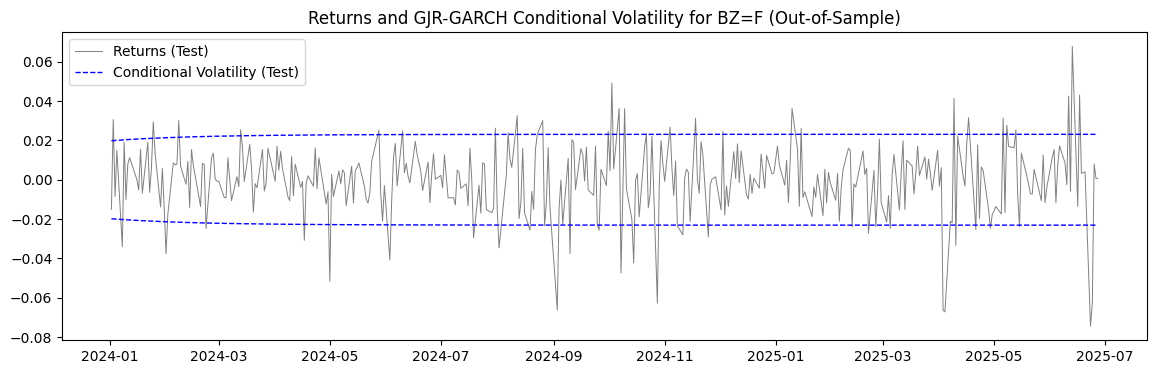

In [10]:
plt.figure(figsize=(14, 4))
#plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GJRGARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GJRGARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (Out-of-Sample)")
plt.legend()
plt.show()

In [11]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_volatility_out_of_sample_GJRGARCH.loc[test_returns.index]

# Realized volatility: use squared returns as a proxy
realized_vol = np.sqrt(test_returns ** 2)

# Metrics
mse = mean_squared_error(realized_vol, forecast_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecast_vol)
# corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
# print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000237
Root Mean Squared Error (RMSE): 0.015380
Mean Absolute Error (MAE): 0.013289


## 2.3. XGBoost
### 2.3.1. With only lagged returns as input

In [12]:
from xgboost import XGBRegressor

# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 5

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

# Fit XGBoost regressor
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)


In [13]:
# Forward prediction for 30 days
def recursive_forecast(model, initial_lags, horizon):
    predictions = []
    current_lags = np.array(initial_lags)  # Last n_lags variances from train
    for _ in range(horizon):
        pred = model.predict(current_lags.reshape(1, -1))[0]
        predictions.append(pred)
        current_lags = np.append(current_lags[1:], pred)  # Shift and append pred
    return np.array(predictions)

initial_lags = (train_returns**2)[-n_lags:]
# Predict 30 days ahead
y_pred_xgb = recursive_forecast(xgb, initial_lags, len(test_returns))
y_pred_xgb = pd.Series(y_pred_xgb, index=test_returns.index)

In [14]:
# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb)
# Realized volatility
realized_vol = np.sqrt(test_returns ** 2)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
#corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"XGBoost - MSE: {mse_xgb:.6f}")
print(f"XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"XGBoost - MAE: {mae_xgb:.6f}")
#print(f"XGBoost - Correlation: {corr_xgb:.4f}")

XGBoost - MSE: 0.000152
XGBoost - RMSE: 0.012330
XGBoost - MAE: 0.009165


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_42660\3058111675.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_42660\3058111675.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)


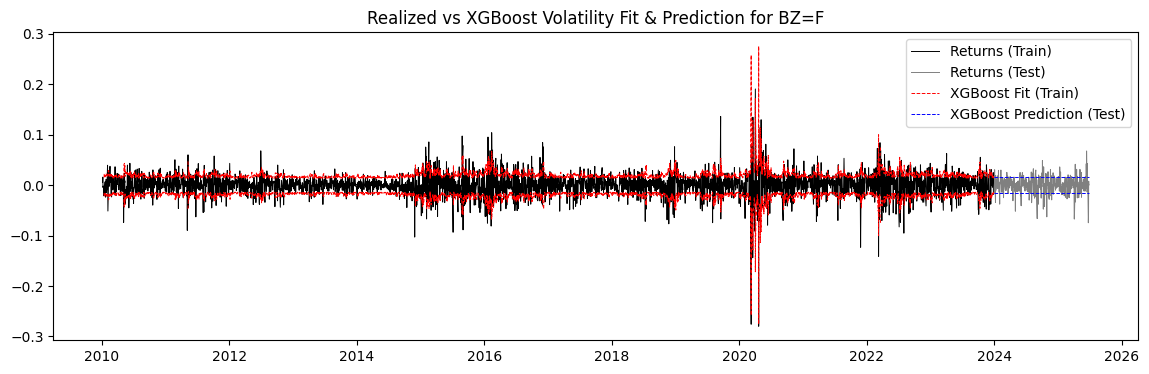

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb.index.to_timestamp(), np.sqrt(y_pred_xgb), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

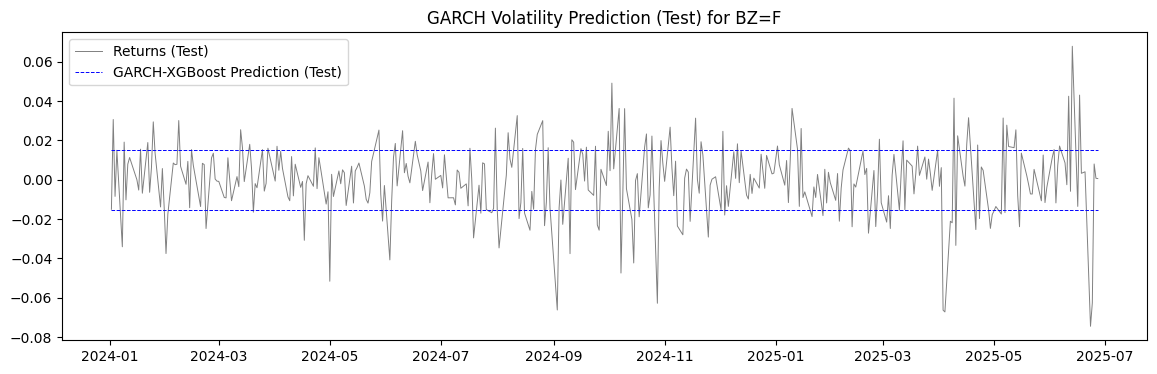

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_xgb.index.to_timestamp(), np.sqrt(y_pred_xgb), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb.index.to_timestamp(), -np.sqrt(y_pred_xgb), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GARCH Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

## 2.4. Hybrid: GARCH-XGBoost/GJR-GARCH - XGBoost
1. Take outputs from GARCH (predicted volatility) both from insample (train) and out of sample (predict())
2. Fit the XGBoost model both on the lagged returns and outputs from GARCH
3. Predict forward recursively

### 2.4.1. GARCH-XGBoost

In [17]:
# Add GARCH volatility residuals as additional exogenous variables
# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 5

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

X_train_lagged['garch_var'] = conditional_variance_in_sample_GARCH.loc[X_train_lagged.index]
X_test_lagged['garch_var'] = conditional_variance_out_of_sample_GARCH.loc[X_test_lagged.index]

# Fit XGBoost regressor with the new feature
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)

# Predict
# y_pred_xgb = xgb.predict(X_test_lagged)



In [18]:
def recursive_hybrid_forecast(model, initial_lags, garch_forecast_var, horizon):
    predictions = []
    current_lags = np.array(initial_lags)  # Last n_lags variances from train
    for i in range(horizon):
        # Prepare input row: lags + garch_var for this step
        input_row = pd.DataFrame([current_lags], columns=[f"lag_{j}" for j in range(1, n_lags + 1)])
        input_row['garch_var'] = garch_forecast_var.iloc[i]
        pred = model.predict(input_row)[0]
        predictions.append(pred)
        current_lags = np.append(current_lags[1:], pred)  # Update lags
    return np.array(predictions)

initial_lags = (train_returns**2)[-n_lags:]
y_pred_xgb_hybrid = recursive_hybrid_forecast(
    xgb, initial_lags, conditional_variance_out_of_sample_GARCH, len(test_returns))
y_pred_xgb_hybrid = pd.Series(y_pred_xgb_hybrid, index=test_returns.index)
y_pred_xgb_hybrid

Date
2024-01-02    0.000446
2024-01-03    0.000446
2024-01-04    0.000446
2024-01-05    0.000446
2024-01-08    0.000446
                ...   
2025-06-23    0.000511
2025-06-24    0.000511
2025-06-25    0.000511
2025-06-26    0.000511
2025-06-27    0.000511
Freq: D, Length: 374, dtype: float32

In [19]:
# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb_hybrid)
# Realized volatility
realized_vol = np.sqrt(test_returns ** 2)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GARCH-XGBoost - MSE: {mse_xgb:.6f}")
print(f"GARCH-XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"GARCH-XGBoost - MAE: {mae_xgb:.6f}")
# print(f"GARCH-XGBoost - Correlation: {corr_xgb:.4f}")

GARCH-XGBoost - MSE: 0.000230
GARCH-XGBoost - RMSE: 0.015170
GARCH-XGBoost - MAE: 0.013056


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_42660\3259251703.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_42660\3259251703.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)


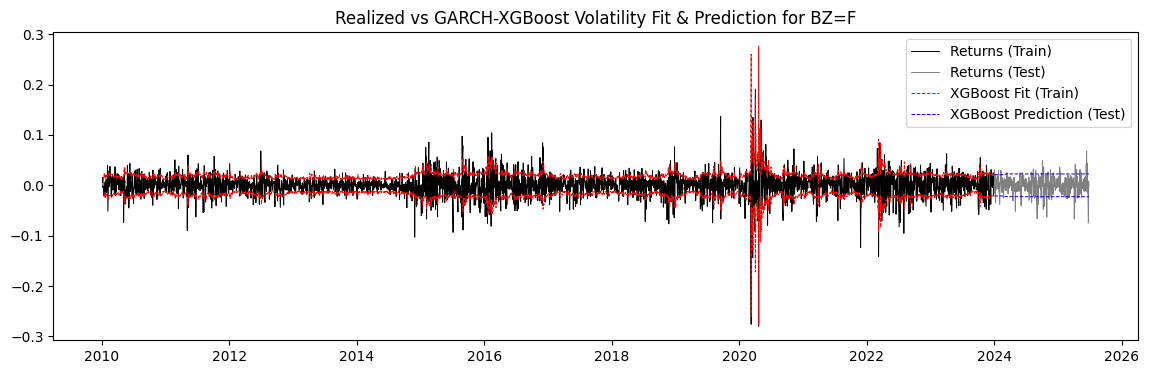

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), np.sqrt(y_pred_xgb_hybrid), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), -np.sqrt(y_pred_xgb_hybrid), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

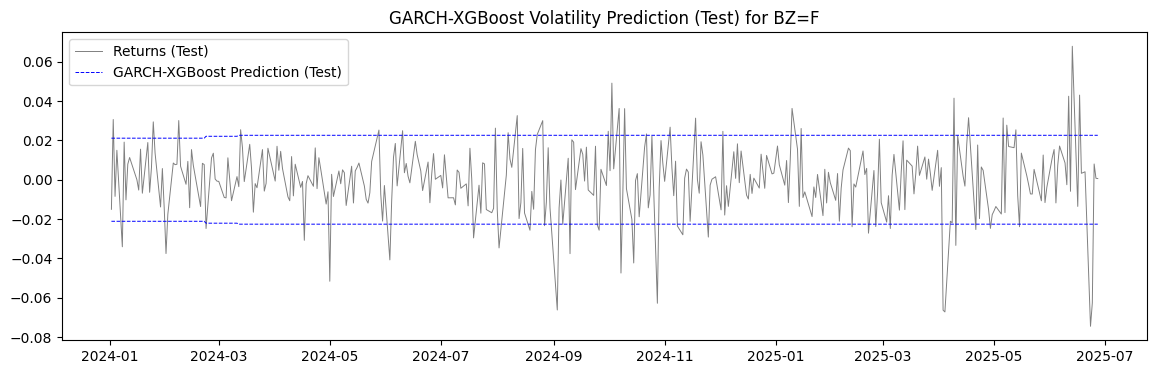

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), np.sqrt(y_pred_xgb_hybrid), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), -np.sqrt(y_pred_xgb_hybrid), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GARCH-XGBoost Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

### 2.4.2. GJR-GARCH - XGBoost

In [22]:
# Add GARCH volatility residuals as additional exogenous variables
# Prepare lagged features for XGBoost: use past days' returns as predictors
n_lags = 5

def make_lagged_features(series, n_lags):
    df = pd.concat([series.shift(i) for i in range(1, n_lags + 1)], axis=1)
    df.columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
    return df

# Training set
X_train_lagged = make_lagged_features(train_returns, n_lags).dropna()
y_train_lagged = (train_returns ** 2).loc[X_train_lagged.index] # variance

# Test set
X_test_lagged = make_lagged_features(test_returns, n_lags).dropna()
y_test_lagged = (test_returns ** 2).loc[X_test_lagged.index] # variance

X_train_lagged['garch_var'] = conditional_variance_in_sample_GJRGARCH.loc[X_train_lagged.index]
X_test_lagged['garch_var'] = conditional_variance_out_of_sample_GARCH.loc[X_test_lagged.index]

# Fit XGBoost regressor with the new feature
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train_lagged, y_train_lagged)

# In-sample prediction (train set)
y_pred_xgb_train = xgb.predict(X_train_lagged)
y_pred_xgb_train = pd.Series(y_pred_xgb_train, index=y_train_lagged.index)

# Predict
# y_pred_xgb = xgb.predict(X_test_lagged)



In [23]:
def recursive_hybrid_forecast(model, initial_lags, garch_forecast_var, horizon):
    predictions = []
    current_lags = np.array(initial_lags)  # Last n_lags variances from train
    for i in range(horizon):
        # Prepare input row: lags + garch_var for this step
        input_row = pd.DataFrame([current_lags], columns=[f"lag_{j}" for j in range(1, n_lags + 1)])
        input_row['garch_var'] = garch_forecast_var.iloc[i]
        pred = model.predict(input_row)[0]
        predictions.append(pred)
        current_lags = np.append(current_lags[1:], pred)  # Update lags
    return np.array(predictions)

initial_lags = (train_returns**2)[-n_lags:]
y_pred_xgb_hybrid = recursive_hybrid_forecast(
    xgb, initial_lags, conditional_variance_out_of_sample_GARCH, len(test_returns))
y_pred_xgb_hybrid = pd.Series(y_pred_xgb_hybrid, index=test_returns.index)

In [24]:
# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_xgb_hybrid)
# Realized volatility
realized_vol = np.sqrt(test_returns ** 2)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GJRGARCH-XGBoost - MSE: {mse_xgb:.6f}")
print(f"GJRGARCH-XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"GJRGARCH-XGBoost - MAE: {mae_xgb:.6f}")
# print(f"GJRGARCH-XGBoost - Correlation: {corr_xgb:.4f}")

GJRGARCH-XGBoost - MSE: 0.000219
GJRGARCH-XGBoost - RMSE: 0.014795
GJRGARCH-XGBoost - MAE: 0.012640


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


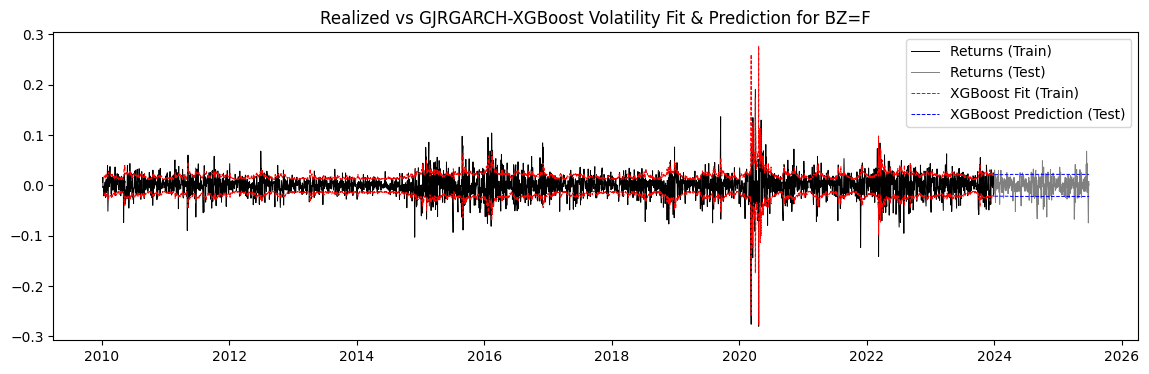

In [25]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), np.sqrt(y_pred_xgb_train), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), np.sqrt(y_pred_xgb_hybrid), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_train_lagged.index.to_timestamp(), -np.sqrt(y_pred_xgb_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), -np.sqrt(y_pred_xgb_hybrid), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GJRGARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

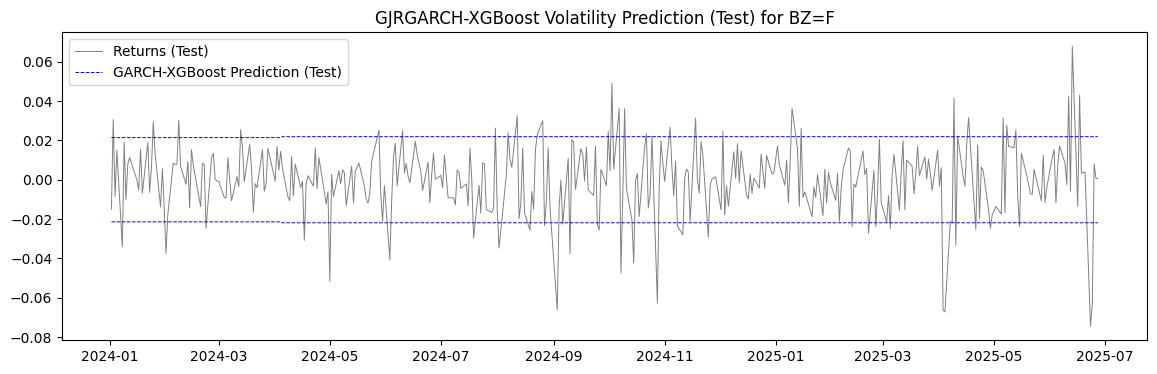

In [26]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), np.sqrt(y_pred_xgb_hybrid), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_xgb_hybrid.index.to_timestamp(), -np.sqrt(y_pred_xgb_hybrid), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GJRGARCH-XGBoost Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

## 2.5. LSTM

In [27]:
# Assume df_brent is your full DataFrame with 'Volatility' column (historical data up to "now")
# Split as before (for training and optional evaluation)


# Scale data (LSTM sensitive to scale)
scaler = MinMaxScaler()
# # train_scaled = scaler.fit_transform(train_brent['Volatility'].values.reshape(-1,1))
# # test_scaled = scaler.transform(test_brent['Volatility'].values.reshape(-1,1))
train_scaled = scaler.fit_transform((train_returns**2).values.reshape(-1,1))
test_scaled = scaler.transform((test_returns**2).values.reshape(-1,1))


WINDOW=30

# Create sequences from train only
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window=WINDOW)

In [28]:
# Build and train LSTM (as before)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Function for recursive forward prediction (no leakage)
def forecast_forward(model, last_window_scaled, scaler, horizon):
    """
    Predicts 'horizon' steps ahead using only the initial historical window.
    - last_window_scaled: Scaled array of last 'window' historical volatilities (shape: (window, 1))
    - Returns: Array of 'horizon' predicted volatilities (original scale)
    """
    predictions = []
    current_window = last_window_scaled.copy()
    
    for _ in range(horizon):
        # Prepare input: (1, window, 1)
        input_seq = current_window.reshape(1, current_window.shape[0], 1)
        
        # Predict next step (scaled)
        next_pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        
        # Append to predictions
        predictions.append(next_pred_scaled)
        
        # Update window: remove oldest, add new prediction
        current_window = np.append(current_window[1:], [[next_pred_scaled]], axis=0)
    
    # Inverse scale all predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions

# In-sample prediction for LSTM (train set)
y_pred_lstm_train_scaled = model.predict(X_train, verbose=0).flatten()
y_pred_lstm_train = scaler.inverse_transform(y_pred_lstm_train_scaled.reshape(-1, 1)).flatten()
y_pred_lstm_train = pd.Series(y_pred_lstm_train, index=train_returns.index[WINDOW:])

# Get the last historical window (from end of train or full historical data)
# Use end of train for OOS simulation; in production, use all available up to now
last_window_scaled = train_scaled[-WINDOW:]  # Assuming window=30

# Generate forward predictions (e.g., 182 days ahead)
y_pred_lstm = forecast_forward(model, last_window_scaled, scaler, horizon=len(test_returns))
y_pred_lstm = pd.Series(y_pred_lstm, index=test_returns.index)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


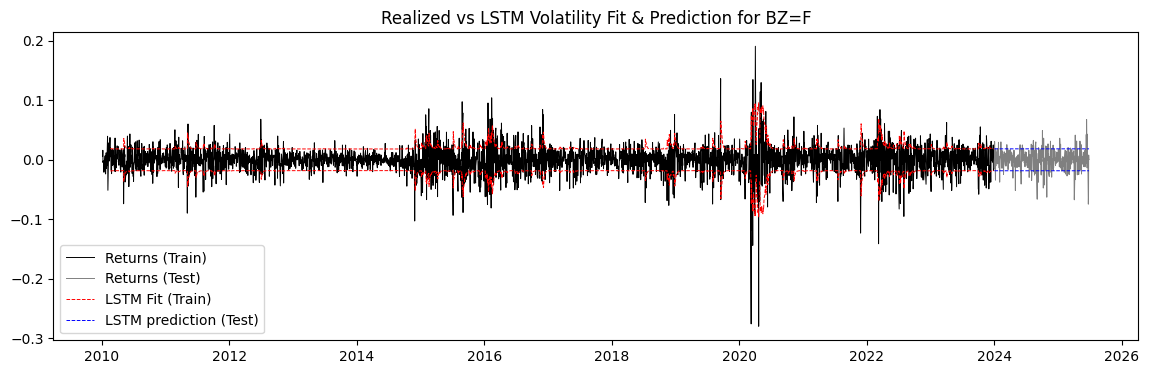

In [30]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_lstm_train.index, np.sqrt(y_pred_lstm_train), label='LSTM Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(test_returns.index, np.sqrt(y_pred_lstm), label='LSTM prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_lstm_train.index, -np.sqrt(y_pred_lstm_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(test_returns.index, -np.sqrt(y_pred_lstm), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs LSTM Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

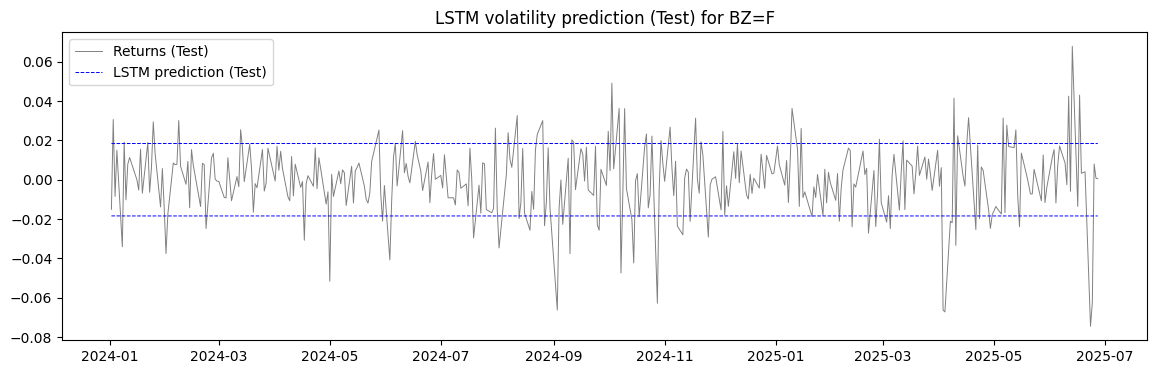

In [31]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_lstm.index, np.sqrt(y_pred_lstm), label='LSTM prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_lstm.index, -np.sqrt(y_pred_lstm), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"LSTM volatility prediction (Test) for {TICKER}")
plt.legend()
plt.show()

In [32]:
# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_lstm)
# Realized volatility
realized_vol = np.sqrt(test_returns**2)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"LSTM - MSE: {mse_xgb:.6f}")
print(f"LSTM - RMSE: {rmse_xgb:.6f}")
print(f"LSTM - MAE: {mae_xgb:.6f}")
# print(f"LSTM - Correlation: {corr_xgb:.4f}")


LSTM - MSE: 0.000174
LSTM - RMSE: 0.013179
LSTM - MAE: 0.010598


## 2.6. Hybrid: GARCH-LSTM

In [33]:
WINDOW=30

df_train = pd.DataFrame({
    'squared_returns': train_returns ** 2,
    'garch_variance': conditional_variance_in_sample_GARCH
}, index = train_returns.index)
df_test = pd.DataFrame({
    'squared_returns': test_returns ** 2,
    'garch_variance': conditional_variance_out_of_sample_GARCH
}, index = test_returns.index)

# Scale data (LSTM sensitive to scale)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)

conditional_variance_out_of_sample_GARCH_scaled = scaler.transform(
    np.column_stack((np.zeros(len(conditional_variance_out_of_sample_GARCH)), conditional_variance_out_of_sample_GARCH))
)[:, 1]  # Scale only GARCH column (placeholder for vol)

def create_sequences_multivar(data, window=30, target_idx=0):  # target_idx=0 for Volatility
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_multivar(train_scaled, window=WINDOW, target_idx=0)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
# build model
num_features = X_train.shape[2]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], num_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
def forecast_forward_hybrid(model, last_window_scaled, scaler, horizon=182, future_garch_var_scaled=None):
    # Initialize list to store predictions
    predictions = []
    # Make a copy of the last historical window (shape: [window, 2 features])
    current_window = last_window_scaled.copy()
    
    # If no future GARCH variance is provided, use the last value for all future steps
    if future_garch_var_scaled is None:
        future_garch_var_scaled = np.repeat(current_window[-1, 1], horizon)
    
    # Loop for each step in the forecast horizon
    for step in range(horizon):
        # Reshape current window for LSTM input: (1, window, num_features)
        input_seq = current_window.reshape(1, current_window.shape[0], current_window.shape[1])
        # Predict next volatility (scaled) using the model
        next_pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        # Store prediction
        predictions.append(next_pred_scaled)
        
        # Prepare new row: predicted volatility + next GARCH variance (both scaled)
        new_row = np.array([[next_pred_scaled, future_garch_var_scaled[step]]])
        # Slide window forward: drop oldest, append new prediction
        current_window = np.append(current_window[1:], new_row, axis=0)
    
    # Inverse scale predictions to original scale (only volatility column)
    predictions = scaler.inverse_transform(
        np.column_stack((np.array(predictions), np.zeros((horizon, 1))))
    )[:, 0]

    # Return array of predicted volatilities (original scale)
    return predictions


# Last historical window (from full data; adjust as needed)
last_window_scaled = train_scaled[-WINDOW:]

# In-sample prediction for LSTM hybrid (train set)
y_pred_lstm_hybrid_train_scaled = model.predict(X_train, verbose=0).flatten()
y_pred_lstm_hybrid_train = scaler.inverse_transform(
    np.column_stack((y_pred_lstm_hybrid_train_scaled, np.zeros(len(y_pred_lstm_hybrid_train_scaled))))
)[:, 0]
y_pred_lstm_hybrid_train = pd.Series(y_pred_lstm_hybrid_train, index=train_returns.index[WINDOW:])

# Generate predictions out of sample
y_pred_lstm_hybrid = forecast_forward_hybrid(
    model,
    last_window_scaled,
    scaler,
    horizon=len(test_returns),
    future_garch_var_scaled=conditional_variance_out_of_sample_GARCH_scaled)
y_pred_lstm_hybrid = pd.Series(y_pred_lstm_hybrid, index=test_returns.index)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


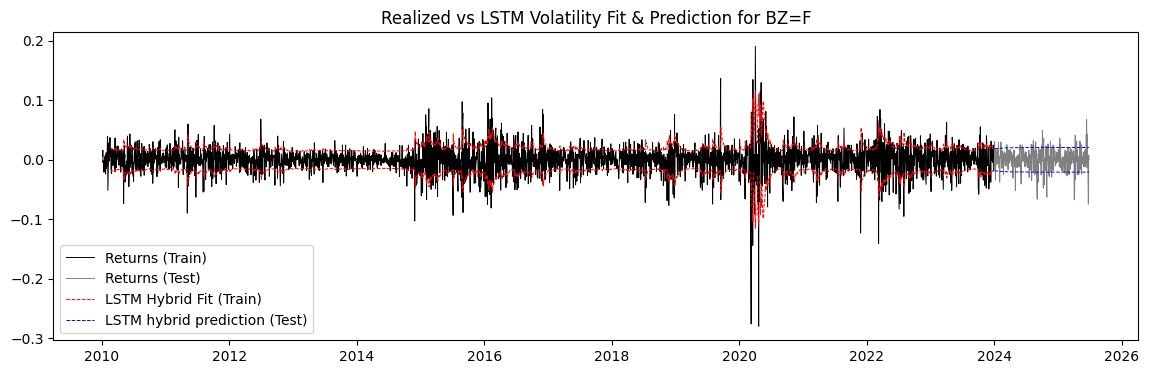

In [36]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_lstm_hybrid_train.index, np.sqrt(y_pred_lstm_hybrid_train), label='LSTM Hybrid Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(test_returns.index, np.sqrt(y_pred_lstm_hybrid), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_lstm_hybrid_train.index, -np.sqrt(y_pred_lstm_hybrid_train), color='red', linestyle='--', linewidth=0.7)
plt.plot(test_returns.index, -np.sqrt(y_pred_lstm_hybrid), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs LSTM Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

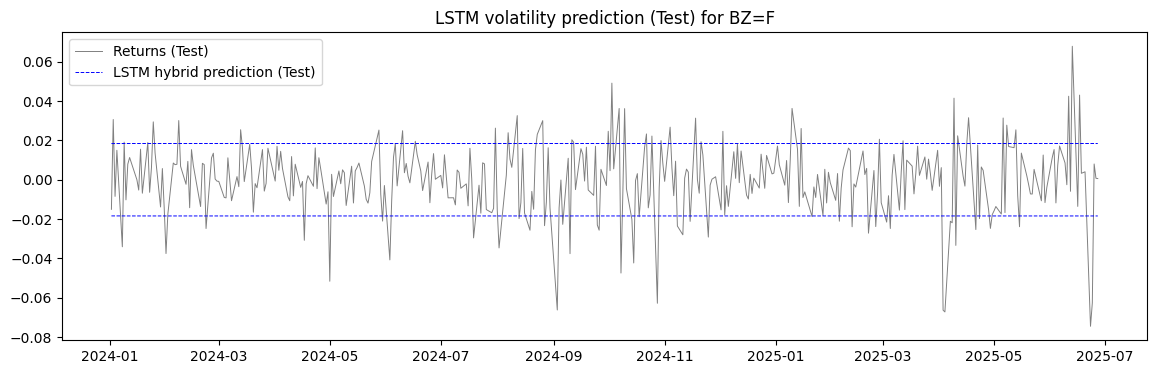

In [37]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(y_pred_lstm_hybrid.index, np.sqrt(y_pred_lstm), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(y_pred_lstm_hybrid.index, -np.sqrt(y_pred_lstm), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"LSTM volatility prediction (Test) for {TICKER}")
plt.legend()
plt.show()

In [38]:
# Forecasted volatility (out-of-sample)
forecast_vol = np.sqrt(y_pred_lstm_hybrid)
# Realized volatility
realized_vol = np.sqrt(test_returns**2)

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"LSTM hybrid - MSE: {mse_xgb:.6f}")
print(f"LSTM hybrid - RMSE: {rmse_xgb:.6f}")
print(f"LSTM hybrid - MAE: {mae_xgb:.6f}")
# print(f"LSTM hybrid - Correlation: {corr_xgb:.4f}")

LSTM hybrid - MSE: 0.000199
LSTM hybrid - RMSE: 0.014091
LSTM hybrid - MAE: 0.011788
